In [178]:
import altair as alt
import pandas as pd
from vega_datasets import data
import networkx as nx
import matplotlib.pyplot as plt
import nx_altair as nxa
from itertools import chain
from pyvis.network import Network
import numpy as np

In [179]:
#!pip install nx_altair

#### First visualization: Topics as nodes and connections by shared repositories
Based on: https://altair-viz.github.io/gallery/airport_connections.html

In [303]:
# Read our cleaned data
repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0).drop_duplicates(subset=['name'])
contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0).drop_duplicates(subset=['login'])
repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)

In [181]:
#get list of repos for each simplified topic
u = repo_topic_relation.groupby("topic_simple")["id"].agg(list)

#get list of topics included in each simplified topic
t = repo_topic_relation.groupby("topic_simple")["topic"].agg(list)
t1 = [(len(i),set(i)) for i in t]
t1.sort()

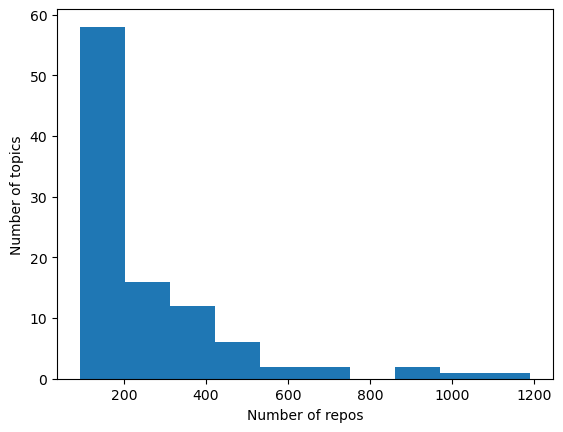

In [182]:
# Make histogram of distibution of number of repositories that share a topic

l = [(len(r),t, r) for t,r in zip(u.index, u)]
l.sort()
plt.hist([le for le, t, r in l[-100:]])
plt.ylabel('Number of topics')
plt.xlabel('Number of repos')
plt.show()

In [244]:
#create a set of edges to build of a graph from, where two topics will have an edge if the number of shared repositories is above a threshold

threshold = 30 # number of repos shared between two topics to have an edge
top_n = 200 # number of topics to look at

edges = set()
topics = [(le,t) for le,t,r in l[-top_n:]]
topics.sort(reverse=True)


for l1, topic1, repo1 in l[-top_n:]:
    for l2, topic2, repo2 in l[-top_n:]:
        shared_repos = len(set(repo1)&set(repo2))
        if (topic1 != topic2) & (shared_repos>threshold) & ((topic1,topic2,shared_repos) not in edges) & ((topic2,topic1,shared_repos) not in edges):
            edges.add((topic1,topic2,shared_repos))
print('Number of edges found:', len(edges), '. Number of topics included:',top_n)           

Number of edges found: 184 . Number of topics included: 200


In [262]:
#colors = ['3FEDED','2B8FD2','4A2A25','2A3601','16D64D','08195A','9BC30E','7DB78F','FD70F9','BFB7D1','AFC63B','F7DD27','104DEF','61731A','09CEA8','46D722','53E5ED','C1C45E','6D4EA3','FF74C4','B053B5','235FDC','015DEE','7D0BDF','AD86A9','0F91A9','11D2E7','6E1EA7','6D7333','68C333','B40834','D3C6C1','37F46C','A56AC4','D33DA5','0141CB','1F4F65','374D37']
#color_searchword_dict = dict(topics[i]:colors[i] for i in range(len(topics)))
boldLabel_lim = topics[round(top_n/10)][0]

G = nx.Graph(nodes=topics)
for le, t in topics:
    if le>boldLabel_lim:
        G.add_node(t, name=t, size=le*0.03, mass=le*0.005, bold=True)
    else:
        G.add_node(t, name=t, size=le*0.03, mass=le*0.005)

for e in edges:
    G.add_edge(e[0],e[1],width=e[2]*0.03)

In [263]:
net = Network(height=800, width=800, notebook=True)
net.from_nx(G)
net.toggle_physics(True)
options = {
          "edges":{
              "color":{"inherit": True},
              "font":{"size":0},
              "smooth":False
          },
          "interaction":{   
               "selectConnectedEdges": True

}}
net.options=options
#net.show_buttons(filter_='edges')
net.show('example.html')

In [209]:
# calculate layout positions, for example using Graphviz's 'twopi' algorithm, calculated via networkx's API.  
pos = nx.random_layout(G)


# Step 2: Convert graph data from NetworkX's format to the pandas DataFrames expected by Altair

pos_df = pd.DataFrame.from_records(dict(node_id=k, x=x, y=y) for k,(x,y) in pos.items())
node_df = pd.DataFrame.from_records(dict(data, **{'node_id': n}) for n,data in G.nodes.data())
edge_data = ((dict(d, **{'edge_id':i, 'end':'source', 'node_id':s}),
              dict(d, **{'edge_id':i, 'end':'target', 'node_id':t}))
             for i,(s,t,d) in enumerate(G.edges.data()))
edge_df = pd.DataFrame.from_records(chain.from_iterable(edge_data))


# Step 3:  Use Altair to encode the graph data as marks in a visualization
x,y = alt.X('x:Q', axis=None), alt.Y('y:Q', axis=None)
# use a lookup to tie position data to the other graph data
select_repo = alt.selection_single(
     # Display the topic keyword on mouseover (assuming we grouped by topic)
     on="mouseover", nearest=True, fields=["name"], empty="none"
 )

node_position_lookup = {
    'lookup': 'node_id', 
    'from_': alt.LookupData(data=pos_df, key='node_id', fields=['x', 'y'])
}
nodes = (
    alt.Chart(node_df)
    .mark_circle(size=300, opacity=1)
    .encode(x=x, y=y, color=alt.Color('rank:N', legend=None))
    .transform_lookup(**node_position_lookup)
    .add_selection(select_repo)
)
edges = (
    alt.Chart(edge_df)
    .mark_line(color='gray')
    .encode(x=x, y=y, detail='edge_id:N')  # `detail` gives one line per edge
    .transform_lookup(**node_position_lookup)
)
chart = (
    (edges+nodes)
    .properties(width=900, height=500,)
    .configure_view(strokeWidth=0)
)
chart


alt.LayerChart(...)

In [131]:
pos_df

,node_id,x,y
0,parser,0.003877,0.030652
1,javascript,0.001589,-0.002052
2,mysql,-0.029539,-0.060230
3,sql,-0.035804,-0.044606
4,statist,-0.043925,-0.025614
...,...,...,...
95,rust,-0.058393,0.111736
96,vue,0.038750,0.002160
97,atom,0.065651,0.011766
98,test,0.700347,0.665295


In [136]:
# Was originally the background image for the airports
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
airports = data.airports.url
flights_airport = data.flights_airport.url

# Original example, TODO: remove
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
select_city = alt.selection_single(
    # Decides which blob is selected by the mouse hover-over.
    # Can maybe forgo this for the static graph
    on="mouseover", nearest=True, fields=["origin"], empty="none"
)

#### Second visualization: Topics as nodes and connections by shared contributors

In [264]:
# Read our cleaned data
repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0)
contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0)
repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)

In [265]:
#get list of repos for each simplified topic
u = repo_topic_relation.groupby("topic_simple")["id"].agg(list)

#get list of contributors for each repo
v = repo_contrib_relation.groupby("Repo")['Contributor'].agg(list)
repo_contrib_dict = dict(zip(v.index,v))

In [266]:
#get list of topics to contributors
l = list()
for t,r in zip(u.index, u):
    current_t = []
    for repo in r:
        if repo in repo_contrib_dict:
            current_t = current_t + repo_contrib_dict[repo]
    l.append((len(set(current_t),t,set(current_t)))
l.sort()

In [289]:
#create a set of edges to build of a graph from, where two topics will have an edge if the number of shared contributors is above a threshold

threshold = 300 # number of repos shared between two topics to have an edge
top_n = 200 # number of topics to look at

edges = set()
topics = [(t,le) for le,t,r in l[-top_n:]]


for l1, topic1, repo1 in l[-top_n:]:
    for l2, topic2, repo2 in l[-top_n:]:
        shared_repos = len(set(repo1)&set(repo2))
        if (topic1 != topic2) & (shared_repos>threshold) & ((topic1,topic2,shared_repos) not in edges) & ((topic2,topic1,shared_repos) not in edges):
            edges.add((topic1,topic2,shared_repos))
print('Number of edges found:', len(edges), '. Number of topics included:',top_n)           

Number of edges found: 82 . Number of topics included: 200


In [290]:
G = nx.Graph(nodes=topics)
for t, le in topics:
    G.add_node(t, name=t, size=le*0.005)

for e in edges:
    G.add_edge(e[0],e[1],width=e[2]*0.01)
    
net = Network(height=800, width=800, notebook=True)

net.from_nx(G)

net.toggle_physics(True)
options = {
          "edges":{
              "color":{"inherit": True},
              "font":{"size":0},
              "smooth":False
          },
          "interaction":{   
               "selectConnectedEdges": True

}}
net.options=options
#net.show_buttons()
net.show('example.html')

#### Third visualization: Repositories as nodes and connections by shared contributors, limiting data to a specific searchword

In [292]:
searchwords = ['3D', 'Algorithm', 'Android', 'API', 'Arduino', 'Atom', 'aws',
       'azure', 'bash', 'bootstrap', 'chrome', 'compiler',
       'crytocurrency', 'data structures', 'database',
       'data visualization', 'deep learning', 'data science',
       'deployment', 'flask', 'front end', 'git', 'google', 'iOS', 'json',
       'library', 'machine learning', 'macOS', 'mobile', 'modeling',
       'natural language processing', 'neural network',
       'operating system', 'parsing', 'software', 'server',
       'virtual reality', 'windows']

colors = ['3FEDED','2B8FD2','4A2A25','2A3601','16D64D','08195A','9BC30E','7DB78F','FD70F9','BFB7D1','AFC63B','F7DD27','104DEF','61731A','09CEA8','46D722','53E5ED','C1C45E','6D4EA3','FF74C4','B053B5','235FDC','015DEE','7D0BDF','AD86A9','0F91A9','11D2E7','6E1EA7','6D7333','68C333','B40834','D3C6C1','37F46C','A56AC4','D33DA5','0141CB','1F4F65','374D37']
color_searchword_dict = {searchwords[i]:colors[i] for i in range(len(searchwords))}

# Change searchword to limit network
searchword = 'Algorithm'
repos_limit = list(repos[repos.search_word==searchword].index)

#get list of contributors for each repo
v = repo_contrib_relation.groupby("Repo")['Contributor'].agg(list)
repo_contrib_dict = dict(zip(v.index,v))
l = [(len(r),t, r) for t,r in zip(v.index, v)]
l.sort()
#[repo_contrib_relation.Repo.isin(repos_limit)]

In [293]:
#create a set of edges to build of a graph from, where two topics will have an edge if the number of shared repositories is above a threshold

l = [i for i in l if i[0]>9]

threshold = 2 # number of repos shared between two topics to have an edge
top_n = len(l) # number of topics to look at

edges = list()
edges_short = set()
topics = [(t,le) for le,t,r in l[-top_n:]]

for l1, repo1, contrib1 in l[-top_n:]:
    for l2, repo2, contrib2 in l[-top_n:]:
        shared_contribs = list(set(contrib1)&set(contrib2))
        shared_contribs_len = len(shared_contribs)
        if (repo1 != repo2) & (shared_contribs_len>threshold) & ((repo1,repo2) not in edges_short) & ((repo2,repo1) not in edges_short):
            edges_short.add((repo1,repo2))
            edges.append((repo1,repo2,shared_contribs_len,shared_contribs))
print('Number of edges found:', len(edges), '. Number of repositories included:',top_n)          

Number of edges found: 4656 . Number of repositories included: 8607


In [305]:
for t,l in topics:
    if type(t) != int:
        print(t)

In [175]:
#edges1 = [e for e in edges]
edges2 = [e for e in edges]

In [326]:
G = nx.Graph(nodes=topics)
for t, le in topics:
    if t in repos.index:
        G.add_node(t, name=t,size=min(50,0.5*int(np.sqrt(repos.loc[t,'stargazers_count']+1))), color=color_searchword_dict[repos.loc[t,'search_word']])
    else:
        G.add_node(t, name=t, size=1)

for e in edges:
    contrib_followers = [contributors.loc[c,'followers'] for c in e[3] if c in contributors.index]
    if contrib_followers:
        G.add_edge(e[0],e[1],width=min(35,0.1*int(np.sqrt(np.average(contrib_followers)))), inherit=False)
    else:
        G.add_edge(e[0],e[1],width=1, inherit=False)
def remove_small_components(graph, n=3):
    for component in list(nx.connected_components(graph)):
        if len(component)<n:
            for node in component:
                graph.remove_node(node)
    return graph
    
#optional remove small components
G = remove_small_components(G, n=10)

net = Network(height=800, width=800, notebook=True)
net.from_nx(G)
net.toggle_physics(True)
options = {
          "nodes":{
              "font":{"size":0}
          },
          "edges":{
              "color":{"inherit": False},
              "font":{"size":0},
              "smooth":False
          },
          "physics":{
              "barnesHut": {"damping": 1}
          },
          "interaction":{   
               "selectConnectedEdges": True

}}
#net.options=options

net.show_buttons()
net.show('example.html')

In [113]:
len([i for i in l if i[0]>9])

8607

In [380]:
class social_network:
    def __init__(self):
        #load all scraped datasets
        self.repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0).drop_duplicates(subset=['name'])
        self.contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0).drop_duplicates(subset=['login'])
        self.repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
        self.repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)
        
        #create an empty dictionary for future edge lists
        self.edgeList_dict = dict()
        self.get_mappings()
        
        self.tr_options = {
                  "edges":{
                      "color":{"inherit": True},
                      "font":{"size":0},
                      "smooth":False
                  }
        }
        self.rc_options = {
                  "nodes":{
                      "font":{"size":0}
                  },
                  "edges":{
                      "color":{"inherit": False},
                      "font":{"size":0},
                      "smooth":False
                  },
                  "physics":{
                      "barnesHut": {"damping": 1}
                  }
        }
        self.tc_options = {
                  "edges":{
                      "color":{"inherit": True},
                      "font":{"size":0},
                      "smooth":False
                  }
        }
        
        self.options = {'topic-repo':self.tr_options,
                       'topic-contributor':self.tc_options,
                       'repo-contributor':self.rc_options}

        self.width_functions = {'topic-repo':lambda x: x*0.03,
                               'topic-contributor':lambda x: x*0.01,
                               'repo-contributor':lambda x: x*0.03
                               }
        self.size_functions = {'topic-repo':lambda x: x*0.03,
                               'topic-contributor':lambda x: x*0.005,
                               'repo-contributor':lambda x: x*0.03
                               }
        self.mass_functions = {'topic-repo':lambda x: x*0.005,
                               'topic-contributor':lambda x: x*0.005,
                               'repo-contributor':lambda x: x*0.03
                               }
        self.color_functions = {'topic-repo':lambda x: x*0.005,
                               'topic-contributor':lambda x: x*0.03,
                               'repo-contributor':lambda x: x*0.03
                               }
        
    def change_width_function(self, option, func):
        self.width_functions[option] = func
        
    def change_size_function(self, option, func):
        self.size_functions[option] = func
    
    def change_mass_function(self, option, func):
        self.mass_functions[option] = func
    
    def get_mappings(self):
        #get list of repos for each simplified topic
        self.tr_list = self.repo_topic_relation.groupby("topic_simple")["id"].agg(list)
        self.TR = [(len(r),t, r) for t,r in zip(self.tr_list.index, self.tr_list)]
        self.TR.sort(reverse=True)
        
        #get list of contributors for each repo
        self.rc_list = self.repo_contrib_relation.groupby("Repo")['Contributor'].agg(list)
        self.repo_contrib_dict = dict(zip(self.rc_list.index,self.rc_list))
        self.RC = [(len(c),r, c) for r,c in zip(self.rc_list.index, self.rc_list)]
        self.RC.sort(reverse=True)
        
        #get list of contributors for each simplified topic
        self.TC = list()
        for t,r in zip(self.tr_list.index, self.tr_list):
            current_t = []
            for repo in r:
                if repo in self.repo_contrib_dict:
                    current_t = current_t + self.repo_contrib_dict[repo]
            self.TC.append((len(set(current_t)),t,set(current_t)))
        self.TC.sort(reverse=True)
        
    def get_edge_list(self, option, threshold=20, top_n='all'):
        if f"{option}_{threshold}_{top_n}" not in self.edgeList_dict:
            edges = list()
            edges_short = set()
            
            if option == 'topic-repo':
                if top_n != 'all':
                    mapping = self.TR[:top_n]
                else:
                    mapping = self.TR
                      
            elif option == 'topic-contributor':
                if top_n != 'all':
                    mapping = self.TC[:top_n]
                else:
                    mapping = self.TC
                
            elif option == 'repo-contributor':
                if top_n != 'all':
                    mapping = self.RC[:top_n]
                else:
                    mapping = self.RC
            else:
                raise ValueError
            
            for l1, t1, r1 in mapping:
                for l2, t2, r2 in mapping:
                    shared = set(r1)&set(r2)
                    shared_len = len(shared)
                    if (t1 != t2) & (shared_len>threshold) & ((t1,t2) not in edges_short) & ((t2,t1) not in edges_short):
                        edges_short.add((t1,t2))
                        edges.append((t1,t2,shared_len,shared))
                        
            self.edgeList_dict[f"{option}_{threshold}_{top_n}"]=edges
        
    def make_network(self, option, threshold=20, top_n='all'):

        
        
        if f"{option}_{threshold}_{top_n}" not in self.edgeList_dict:
            raise ValueError
        self.G = nx.Graph()
        edges = self.edgeList_dict[f"{option}_{threshold}_{top_n}"]
        
        if option == 'topic-repo':
            if top_n != 'all':
                mapping = self.TR[:top_n]
            else:
                mapping = self.TR
                      
        elif option == 'topic-contributor':
            if top_n != 'all':
                mapping = self.TC[:top_n]
            else:
                mapping = self.TC

        elif option == 'repo-contributor':
            if top_n != 'all':
                mapping = self.RC[:top_n]
            else:
                mapping = self.RC
        nodes = [(t,le) for le,t,r in mapping]
        
        for n, le in nodes:
            self.G.add_node(n, name=n, size=self.size_functions[option](le), mass=self.mass_functions[option](le))

        for e in edges:
            self.G.add_edge(e[0],e[1],width=self.width_functions[option](e[2]))
            
    def visualize_network(self, option, show_buttons=False, html='network.html'):
        net = Network(height=800, width=800, notebook=True)
        net.from_nx(self.G)
        net.toggle_physics(True)
        if show_buttons:
            net.show_buttons()
        else:
            net.options=self.options[option]
        net.show(html)
        
        
    
        
        
        

In [381]:
sn = social_network()

In [388]:
sn.get_edge_list('topic-repo', threshold=10, top_n=200)
sn.get_edge_list('topic-contributor', threshold=10, top_n=200)
sn.get_edge_list('repo-contributor', threshold=2, top_n = 5000)

In [389]:
sn.edgeList_dict.keys()

dict_keys(['topic-repo_10_200', 'topic-contributor_10_200', 'repo-contributor_2_200', 'repo-contributor_2_5000'])

In [390]:
sn.make_network('repo-contributor', threshold=2, top_n=5000)

In [391]:
sn.visualize_network('repo-contributor')